In [3]:
import pandas as pd
import numpy as np
import scipy
import pylab as pl
import sklearn as sk
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
%matplotlib inline

In [38]:
data = pd.read_excel('HealthViz County Dataset 6.19.17.xlsx',skiprows=0, header=1, index_col=0)
data.index.name=None

In [5]:
data.shape

(3220, 41)

In [40]:
data.head()

,Unnamed: 1,"Population (residents), 2011-2015","Median household income, 2011-2015","Per capita income, 2011-2015","Gini index of income inequality, 2015","Food stamps (SNAP) (% of households), 2011-2015","Poverty rate (% of residents), 2011-2015","Median property tax ($), 2011-2015","Rent-burdened (% of renter-occupied housing units), 2011-2015","Median gross rent, 2011-2015",...,"Medicare inpatient utilization (% of beneficiaries), 2015","Current cigarette smoking (% of adults), 2006-2012","Diagnosed diabetes (% of adults), 2006-2012","High blood pressure (% of adults), 2006-2012","Obesity (% of adults), 2006-2012","Mortality rate, all causes (deaths per 100,000), 2008-2014","Diabetes mortality (deaths per 100,000), 2008-2014","Influenza and pneumonia mortality (deaths per 100,000), 2008-2014","Septicemia (sepsis) mortality (deaths per 100,000), 2008-2014","Years of potential life lost (YPLL) (life-years lost per 100,000), 2012-2014"
1001,"Autauga County, AL",55221,51219.97561,24974.0,NaN,13.777211,12.879382,455.0,49.407783,881.94923,...,18.20,21.0,10.8,27.3,29.2,917.2,21.5,17.7,19.1,9158.2
1003,"Baldwin County, AL",195121,50194.19774,27317.0,0.4722,9.003563,13.411661,573.0,44.544464,877.95399,...,16.23,22.7,7.5,30.9,25.0,792.7,17.5,10.5,10.0,7393.9
1005,"Barbour County, AL",26932,32924.77284,16824.0,NaN,25.970505,26.727439,301.0,40.946992,578.31099,...,17.60,25.2,11.3,46.4,46.1,914.3,19.4,12.0,12.7,8573.1
1007,"Bibb County, AL",22604,38631.97318,18431.0,NaN,15.781984,16.795878,266.0,35.162950,650.22531,...,17.81,25.6,9.2,39.1,30.5,1029.3,24.5,17.0,20.1,11766.1
1009,"Blount County, AL",57710,45758.48253,20532.0,NaN,13.489623,16.720933,419.0,31.117687,600.28481,...,15.98,22.4,8.6,36.2,34.4,907.0,13.8,32.4,20.8,9332.8


In [7]:

def cov(x,y,w=None):
    '''
    Calculates covariance of x,y weighted by w.
    Parameters
        x,y: pd.Series
        w: pd.Series or None
    Returns
        covariance: float
    '''
    if w is None:
        w = pd.Series(np.ones(x.shape[0]))
        w.index = x.index
        
    numerator = sum(w*(x - np.average(x, weights=w))*(y - np.average(y, weights=w)))
    denominator = sum(w)
    return numerator/denominator

def corr(x, y, w=None, check_nulls = False):
    '''
    Calculates Pearson correlation between x,y weighted by w.
    Parameters
        x,y: pd.Series
        w: pd.Series or None
        check_nulls: Boolean, optional 
    Returns
        covariance: float
    '''
    if w is None:
        w = pd.Series(np.ones(x.shape[0]))
        w.index = x.index
    
    if check_nulls:
        df = pd.concat([x, y, w], axis = 1)
        null_cols  = df.isnull().any(axis = 1)
    
        if null_cols.any():
            x = x[~null_cols]
            y = y[~null_cols]
            w = w[~null_cols]

    return cov(x,y,w)/np.sqrt(cov(x,x,w)*cov(y,y,w))



In [8]:
def df_corr(xs, ys, w=None, method=corr, min_periods=1):
        """
        Compute pairwise correlation of columns, excluding NA/null values
        Parameters
        ----------
        min_periods : int, optional
            Minimum number of observations required per pair of columns
            to have a valid result. 
        Returns
        -------
        y : DataFrame
        
        Modified from pandas:
            https://github.com/pandas-dev/pandas/blob/v0.20.2/pandas/core/frame.py#L4817-L4871
        """
        if isinstance(xs, pd.Series):
            xs = pd.DataFrame(xs)
            
        rows = xs.columns
       
        if isinstance(ys, pd.Series):
            ys = pd.DataFrame(ys)
            
        cols = ys.columns
            
        xmat = xs.values.T
        ymat = ys.values.T

        if min_periods is None:
            min_periods = 1
        #mat = _ensure_float64(mat).T
        corrf = method
        K = len(rows)
        M = len(cols)
        correl = np.empty((K, M), dtype=float)
        xmask = np.isfinite(xmat)
        ymask = np.isfinite(ymat)
        for i, ac in enumerate(xmat):
            for j, bc in enumerate(ymat):
                valid = xmask[i] & ymask[j]
                
                if valid.sum() < min_periods:
                    c = NA
                elif not valid.all():
                    c = corrf(ac[valid], bc[valid], w[valid])
                else:
                    c = corrf(ac, bc, w)
                correl[i, j] = c

        return pd.DataFrame(correl, index=rows, columns=cols)

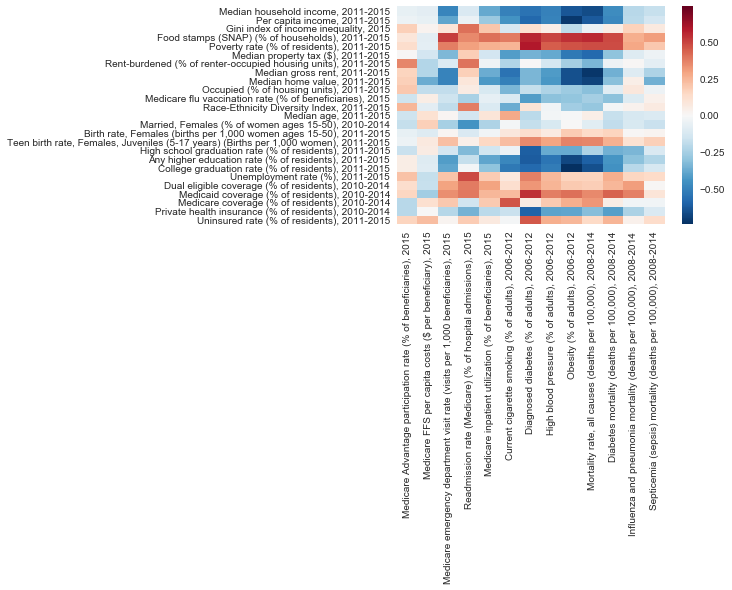

In [9]:
w = data.ix[:,1]
xs = data.ix[:,2:27]
ys = data.ix[:,27:-1]
crs = df_corr(xs,ys,w)
sns.heatmap(crs)

In [7]:
crs

,"Medicare Advantage participation rate (% of beneficiaries), 2015","Medicare FFS per capita costs ($ per beneficiary), 2015","Medicare emergency department visit rate (visits per 1,000 beneficiaries), 2015","Readmission rate (Medicare) (% of hospital admissions), 2015","Medicare inpatient utilization (% of beneficiaries), 2015","Current cigarette smoking (% of adults), 2006-2012","Diagnosed diabetes (% of adults), 2006-2012","High blood pressure (% of adults), 2006-2012","Obesity (% of adults), 2006-2012","Mortality rate, all causes (deaths per 100,000), 2008-2014","Diabetes mortality (deaths per 100,000), 2008-2014","Influenza and pneumonia mortality (deaths per 100,000), 2008-2014","Septicemia (sepsis) mortality (deaths per 100,000), 2008-2014"
"Median household income, 2011-2015",-0.063581,-0.078551,-0.488691,-0.113363,-0.379721,-0.503416,-0.546032,-0.499706,-0.634078,-0.664253,-0.464039,-0.206504,-0.168147
"Per capita income, 2011-2015",-0.043993,-0.059137,-0.391643,-0.050106,-0.277413,-0.441639,-0.583678,-0.497832,-0.714107,-0.623472,-0.478021,-0.201713,-0.135658
"Gini index of income inequality, 2015",0.176471,0.027880,0.094896,0.410381,0.206067,-0.124187,0.121395,0.051298,-0.195172,-0.049095,0.055589,0.168864,0.075316
"Food stamps (SNAP) (% of households), 2011-2015",0.090918,-0.079888,0.513043,0.354434,0.408423,0.385150,0.562364,0.500838,0.544174,0.558794,0.488769,0.270977,0.311705
"Poverty rate (% of residents), 2011-2015",0.133020,-0.070911,0.382318,0.302886,0.265188,0.254274,0.593456,0.450696,0.473008,0.481717,0.481312,0.289662,0.201975
"Median property tax ($), 2011-2015",0.006515,-0.137083,-0.335303,0.180412,-0.133325,-0.416195,-0.352521,-0.379809,-0.529035,-0.575380,-0.299804,-0.095771,-0.037578
"Rent-burdened (% of renter-occupied housing units), 2011-2015",0.362285,-0.217213,-0.106719,0.403068,-0.031934,-0.223791,0.004210,-0.132136,-0.253572,-0.340989,-0.035887,0.007097,-0.073728
"Median gross rent, 2011-2015",0.162855,-0.216222,-0.495552,0.174236,-0.370514,-0.545749,-0.338240,-0.420302,-0.650573,-0.720465,-0.359218,-0.098495,-0.228980
"Median home value, 2011-2015",0.176202,-0.367853,-0.495343,0.087802,-0.425724,-0.509472,-0.341804,-0.433022,-0.652575,-0.685987,-0.310440,0.050310,-0.357029
"Occupied (% of housing units), 2011-2015",0.200241,-0.183135,-0.181269,0.062724,-0.115936,-0.340733,-0.178317,-0.229821,-0.269347,-0.309640,-0.088177,0.084008,-0.039978


In [10]:
def ordered_corrs(xs, y, w):
    '''
    '''
    crs = df_corr(xs,y,w)
    return crs.reindex(crs.ix[:,0].abs().sort_values(ascending=False).index).ix[:,0]

def ordered_heatmap(crs):
    pl.figure()
    sns.heatmap(pd.DataFrame(crs), vmin = -.8, vmax = .8)
    pl.show()

In [ ]:
for y in ys:
    ordered_heatmap(ordered_corrs(xs,ys[y], w))


In [12]:
def drop_nan(X,y, sample_weight=None, drop_threshold = .1, verbose = False):
    '''
    
    drop_threshold: float (between 0 and 1)
        When the proportion of nans in a column is above threshold, drop the column
    '''
    
    # Drop all data without an outcome measure
    valid_y = np.isfinite(y) 
    if verbose:
        dropped = valid_y.count() - valid_y.sum()
        print("Dropped {} rows with nan in outcome variable y\n".format(dropped))
    X = X[valid_y]
    y = y[valid_y]
    
    
    # Drop columns where the proportion of nans is above the drop_threshold
    drop_columns = X.isnull().sum() / X.shape[0] > drop_threshold
    if verbose:
        dropped = X.columns[drop_columns]
        message = "Dropped columns: "
        for d in dropped:
            message += d + "\n"
        print(message)      
    passable_columns = X.columns[~drop_columns]
    X = X[passable_columns]
    
    
    # Drop rows where we find NaNs in the Xs.
    xmask = np.isfinite(X)
    valid_X = xmask.all(axis=1)
    if verbose:
        dropped = valid_X.count() - valid_X.sum()
        print("Dropped {} rows with nans in X".format(dropped))
    X = X[valid_X]
    y = y[valid_X]
    
    if sample_weight is not None:
        sample_weight = sample_weight[valid_y][valid_X]
        return X, y, sample_weight
    
    return X, y

In [13]:
X = xs

for n in range(ys.shape[1]):
    y = ys.ix[:,n]
    a,b,wgt = drop_nan(X,y, sample_weight=1/w)
    lm = linear_model.LinearRegression()
    model = lm.fit(a,b, sample_weight=wgt)
    score = lm.score(a,b, sample_weight=wgt)
    print("R^2 for {var}: {score}".format(var=ys.columns[n], score=score))

R^2 for Medicare Advantage participation rate (% of beneficiaries), 2015: 0.29550503355218427
R^2 for Medicare FFS per capita costs ($ per beneficiary), 2015: 0.22962570982787756
R^2 for Medicare emergency department visit rate (visits per 1,000 beneficiaries), 2015: 0.5238220052199989
R^2 for Readmission rate (Medicare) (% of hospital admissions), 2015: 0.4372809569028271
R^2 for Medicare inpatient utilization (% of beneficiaries), 2015: 0.3811236620967311
R^2 for Current cigarette smoking (% of adults), 2006-2012: 0.3089728613291627
R^2 for Diagnosed diabetes (% of adults), 2006-2012: 0.42152031070032486
R^2 for High blood pressure (% of adults), 2006-2012: 0.34732462270565134
R^2 for Obesity (% of adults), 2006-2012: 0.2964334561757205
R^2 for Mortality rate, all causes (deaths per 100,000), 2008-2014: 0.5302773835915856
R^2 for Diabetes mortality (deaths per 100,000), 2008-2014: 0.3328239971931489
R^2 for Influenza and pneumonia mortality (deaths per 100,000), 2008-2014: 0.25850615

In [15]:
coef= pd.DataFrame(model.coef_, index = a.columns, columns = [b.name])
#coef.sort_values(b.name)

In [16]:
def ols(X,y, drop_threshold = .1, verbose = False):
    X,y = drop_nan(X,y, verbose=True)
    lm = linear_model.LinearRegression()
    model = lm.fit(X,y)
    coef= pd.DataFrame(model.coef_, index = a.columns, columns = [b.name])
    return coef.sort_values(b.name)


In [18]:
ls

Data/                                  README.md
HealthViz County Dataset 6 21 17.csv   correlation_try.py
HealthViz County Dataset 6.19.17.xlsx  to_be_merged.ipynb
HealthViz County Dataset 62117.csv


In [14]:
df = pd.read_csv('HealthViz County Dataset 6 21 17.csv',skiprows=0, header=1, index_col=0, encoding='latin_1')
df.index.name=None

In [15]:
weights = df['Population (residents), 2011-2015']

y = df['Diabetes mortality (deaths per 100,000), 2008-2014']

#var = ['Election margin, winner (Presidential) (% margin), 2016']
controls = ['Population, Non-Hispanic Black (residents), 2011-2015',
'Population, Hispanic or Latino (residents), 2011-2015',
'Population, Asian or Pacific Islander (residents), 2011-2015',
'Median age, 2011-2015',
'Median household income, 2011-2015',
'Poverty rate (% of residents), 2011-2015',
'Share of income, top 5% (% of total income), 2011-2015',
'Dual eligible coverage (% of residents), 2010-2014',
'College graduation rate (% of residents), 2011-2015',
'Graduate education rate (% of residents), 2011-2015',
'Food stamps (SNAP) (% of households), 2011-2015']


#X = df[var + controls]

data_var = 'Readmission rate (Medicare) (% of hospital admissions), 2015'
X = pd.merge(pd.DataFrame(data[data_var]), df[controls],right_index=True, left_index=True )

X,y,w = drop_nan(X,y, weights, verbose = True)

Dropped 737 rows with nan in outcome variable y

Dropped columns: 
Dropped 1 rows with nans in X


In [31]:
X_1 = sm.add_constant(X)
model = sm.OLS(y,X_1)
model2 = sm.WLS(y,X_1,weights=1/w)
model.fit().summary()
#model2.fit().summary()
results = model.fit()
betas = results.params.ix[['Readmission rate (Medicare) (% of hospital admissions), 2015']]
se = results.HC0_se.ix[['Readmission rate (Medicare) (% of hospital admissions), 2015']]

In [25]:
a = results.params.ix[['Readmission rate (Medicare) (% of hospital admissions), 2015']]

In [ ]:
pd.concat([betas, se])

In [20]:
type(results.rsquared)

numpy.float64